# Model testing with quadratic, exponential, and other reward functions on Env-v1

In [3]:
# More tests in reward_testing.py

In [53]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import read_progress

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Plot rewards

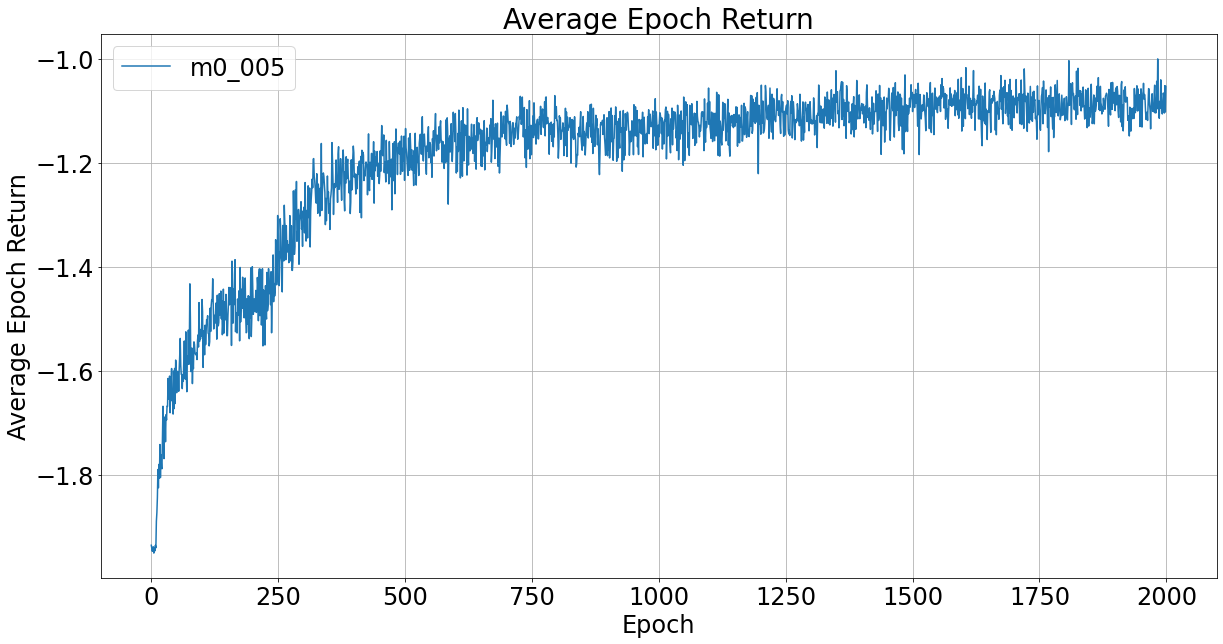

In [182]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

# agent_paths = ['sac_q/']
# agent_paths = ['ddpg_a','ddpg_n','ddpg_n_b','ddpg_q','ddpg_q_b','ddpg_q_e','ddpg_q_ep','ddpg_q_p','ddpg_s']
# agent_paths = ['ddpg_p005','ddpg_p01','ddpg_p05','ddpg_p005_gamma095','ddpg_p005_gamma1']
# agent_paths = ['ddpg_e10','ddpg_e20','ddpg_e40','ddpg_p01e40','ddpg_p01e80']
# agent_paths = ['ddpg_e10_2000epochs','ddpg_e20_2000epochs','ddpg_e40_2000epochs',
#                'ddpg_p01e40_2000epochs','ddpg_p01e80_2000epochs']
agent_paths = ["m0_005"]

for agent_path in agent_paths[:]:
    progress = read_progress(agent_path)
    plt.plot(np.arange(progress.shape[0]), progress[:,1]/abs(max(progress[:,1])))
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
plt.legend(agent_paths,fontsize=24)
# plt.legend(['A','N','NB','Q','QB','QE','QEP','QP'],fontsize=24)
# plt.legend([r'p=0.05,$\gamma$=0.995','p=0.1,$\gamma$=0.995','p=0.5,$\gamma$=0.995','p=0.05,$\gamma$=0.95'],fontsize=24)
# plt.legend(['c=-10','c=-20','c=-40'],fontsize=24)
# plt.savefig('quad_epoch.png')
# plt.savefig('power_epoch.png')
# plt.savefig('exp_epoch.png')
plt.savefig('tmp.png')

## Test an agent

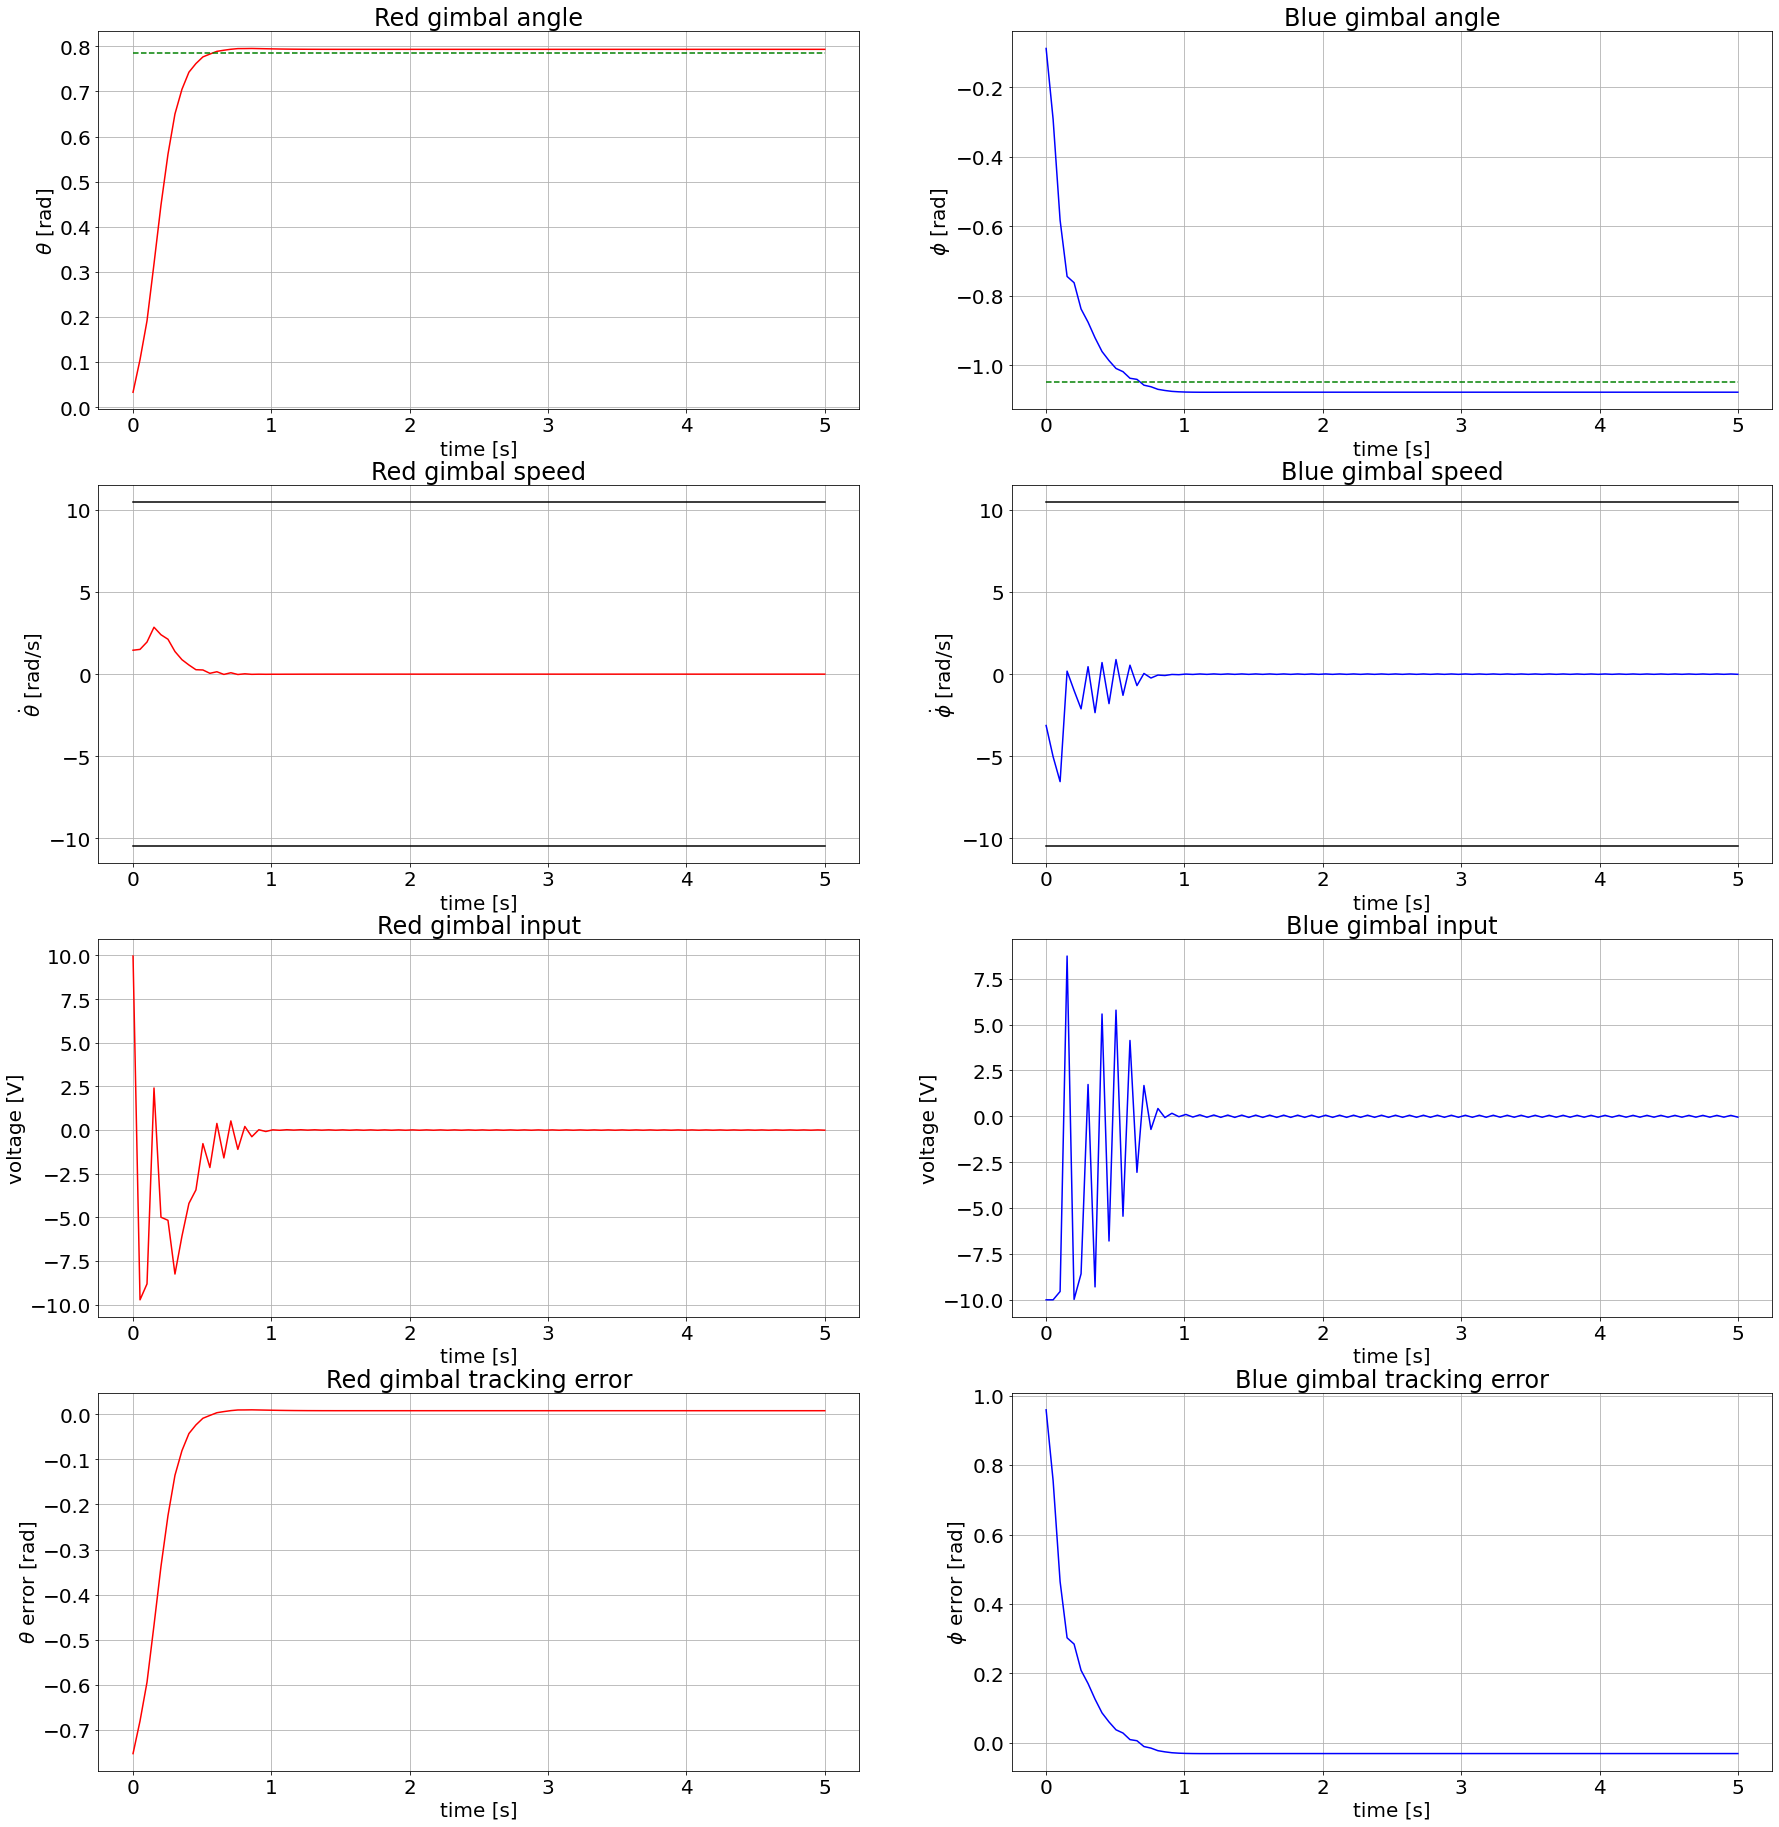

In [181]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'

init_state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,state=init_state)

# agent_paths = ['ddpg_q','ddpg_q_b','ddpg_q_e','ddpg_q_ep','ddpg_q_p','ddpg_a','ddpg_n','ddpg_n_b','ddpg_s']
# agent_paths = ['ddpg_p005','ddpg_p01','ddpg_p05','ddpg_p005_gamma095']
# agent_paths = ['ddpg_e10','ddpg_e20','ddpg_e40','ddpg_p01e40','ddpg_p01e80']
# agent_paths = ['ddpg_e10_2000epochs','ddpg_e20_2000epochs','ddpg_e40_2000epochs',
#                'ddpg_p01e40_2000epochs','ddpg_p01e80_2000epochs']
agent_paths = ["m0_005"]

agent = load_agent(agent_paths[0])
t_end = 5

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

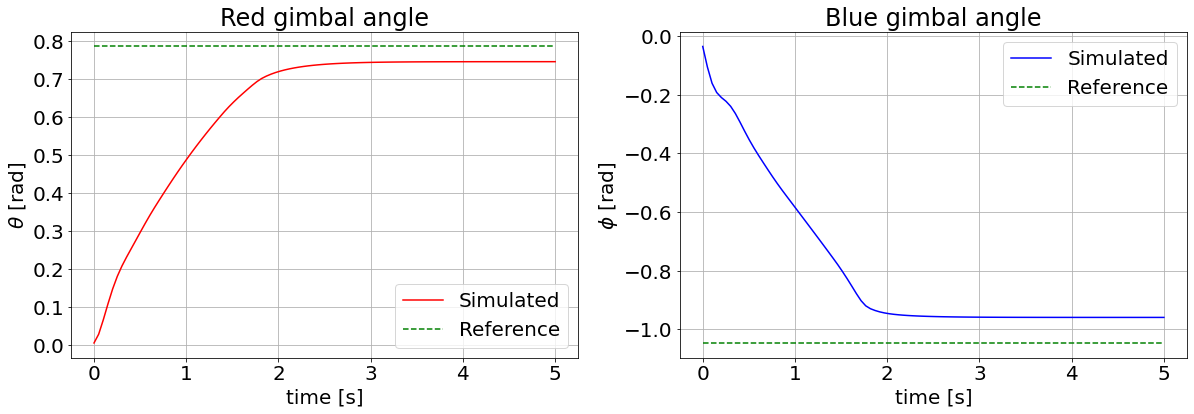

In [52]:
time = np.linspace(0, t_end, len(state_record))
n = 1
f, axs = plt.subplots(n,2,figsize=(20,6*n))

plt.subplot(n,2,1)
plt.title('Red gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\theta$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,env.angle_normalize(state_record[:,0]),'r-')
plt.plot(time,env.angle_normalize(state_record[:,4]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')
plt.legend(['Simulated','Reference'],fontsize=20)

plt.subplot(n,2,2)
plt.title('Blue gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\phi$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,env.angle_normalize(state_record[:,2]),'b-')
plt.plot(time,env.angle_normalize(state_record[:,5]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')
plt.legend(['Simulated','Reference'],fontsize=20)

plt.savefig('tmp.png')

## Evaluate control performance

In [5]:
metrics_QAN = pd.read_csv('Metrics_QAN.csv')
metrics_QAN

,Unnamed: 0,ddpg_q,ddpg_q_b,ddpg_q_e,ddpg_q_ep,ddpg_q_p,ddpg_a,ddpg_n,ddpg_n_b,ddpg_s
0,$\theta$ MAE (rad),0.4171,0.3189,0.3029,0.3520,0.2506,0.3364,0.5583,1.5523,1.5678
1,$\phi$ MAE (rad),0.3757,0.1633,0.2369,0.3833,0.2588,0.2993,0.3614,0.3906,1.5703
2,$\theta$ MSSE (rad),0.3707,0.2354,0.2318,0.2940,0.1822,0.2719,0.4913,1.4152,NaN
3,$\phi$ MSSE (rad),0.3391,0.0926,0.1928,0.3475,0.2089,0.2449,0.3041,0.1334,NaN
4,$\theta$ in bounds (%),37.4500,62.0400,60.2500,48.7100,73.6500,48.9700,29.6300,1.2500,0.0000
5,$\phi$ in bounds (%),36.3600,80.7500,65.2600,35.7300,62.9300,48.6600,45.7100,70.5500,0.0000
6,$\theta$ unsteady (%),8.5000,8.3300,5.7700,5.2000,0.5400,9.0400,7.0100,89.1500,100.0000
7,$\phi$ unsteady (%),14.1800,15.0200,8.5600,14.5300,4.1900,21.7800,14.3400,19.6000,100.0000
8,$\theta$ rise time (s),0.6178,0.5560,0.5878,0.6445,0.7004,0.6267,0.8666,1.2752,NaN
9,$\phi$ rise time (s),0.3794,0.3972,0.4117,0.4599,0.4308,0.4140,0.6435,0.9987,NaN


In [16]:
metrics_PE = pd.read_csv('Metrics_PE.csv')
metrics_PE
# print(metrics_PE.iloc[0:8,[0,4,5,6]].to_latex(index=False,escape=False))

,Unnamed: 0,ddpg_p005,ddpg_p01,ddpg_p05,ddpg_e10_2000epochs,ddpg_e20_2000epochs,ddpg_e40_2000epochs,ddpg_p01e40_2000epochs,ddpg_p01e80_2000epochs
0,$\theta$ MAE (rad),0.3697,0.1939,0.2308,0.2056,0.1946,0.1575,0.1551,0.1546
1,$\phi$ MAE (rad),1.5714,0.1536,0.1585,0.1241,0.1207,1.5671,0.1315,0.1136
2,$\theta$ MSSE (rad),0.1764,0.1129,0.1522,0.1260,0.0912,0.0623,0.0629,0.0604
3,$\phi$ MSSE (rad),1.3913,0.0848,0.1056,0.0621,0.0484,NaN,0.0599,0.0375
4,$\theta$ in bounds (%),0.6100,77.8900,75.5000,88.2600,86.0000,16.6000,95.0900,91.2000
5,$\phi$ in bounds (%),0.0100,81.8000,76.7300,85.3400,89.2300,0.0000,90.5700,94.2600
6,$\theta$ unsteady (%),99.2300,12.3400,6.9700,0.7100,9.8500,82.9000,2.2900,4.6500
7,$\phi$ unsteady (%),99.8700,13.4400,17.3500,11.8300,10.0400,100.0000,7.3600,5.1100
8,$\theta$ rise time (s),0.3155,0.5519,0.5686,0.5593,0.5440,0.4959,0.5020,0.5038
9,$\phi$ rise time (s),0.1005,0.3596,0.3846,0.3274,0.3339,NaN,0.3369,0.3610


In [16]:
# m = pd.concat([metrics_PE.iloc[:,:4], metrics_QAN.iloc[:,1], metrics_P005.iloc[:,2]],axis=1)
# print(m.to_latex(index=False,escape=False))

In [8]:
# metrics_P005_1 = pd.read_csv('Metrics_PE.csv')
# metrics_P005_2 = pd.read_csv('Metrics_Pgamma.csv')
# metrics_P005_3 = pd.read_csv('Metrics_Plen.csv')
# metrics_P005 = pd.concat([metrics_P005_1.iloc[:,:2],metrics_P005_2.iloc[:,1:],metrics_P005_3.iloc[:,1:]],axis=1)
# metrics_P005 = metrics_P005.round(4)
# metrics_P005.to_csv('Metrics_P005.csv',index=False)

In [9]:
metrics_P005 = pd.read_csv('Metrics_P005.csv')
metrics_P005

,Unnamed: 0,ddpg_p005,ddpg_p005_gamma095,ddpg_p005_len300
0,$\theta$ MAE (rad),0.3697,0.1410,0.3746
1,$\phi$ MAE (rad),1.5714,0.0923,0.2029
2,$\theta$ MSSE (rad),0.1764,0.0561,0.2348
3,$\phi$ MSSE (rad),1.3913,0.0366,0.0926
4,$\theta$ in bounds (%),0.6100,98.9000,47.8300
5,$\phi$ in bounds (%),0.0100,95.0500,65.2700
6,$\theta$ unsteady (%),99.2300,0.0300,28.2900
7,$\phi$ unsteady (%),99.8700,4.5200,29.1300
8,$\theta$ rise time (s),0.3155,0.5368,0.5527
9,$\phi$ rise time (s),0.1005,0.3456,0.3577


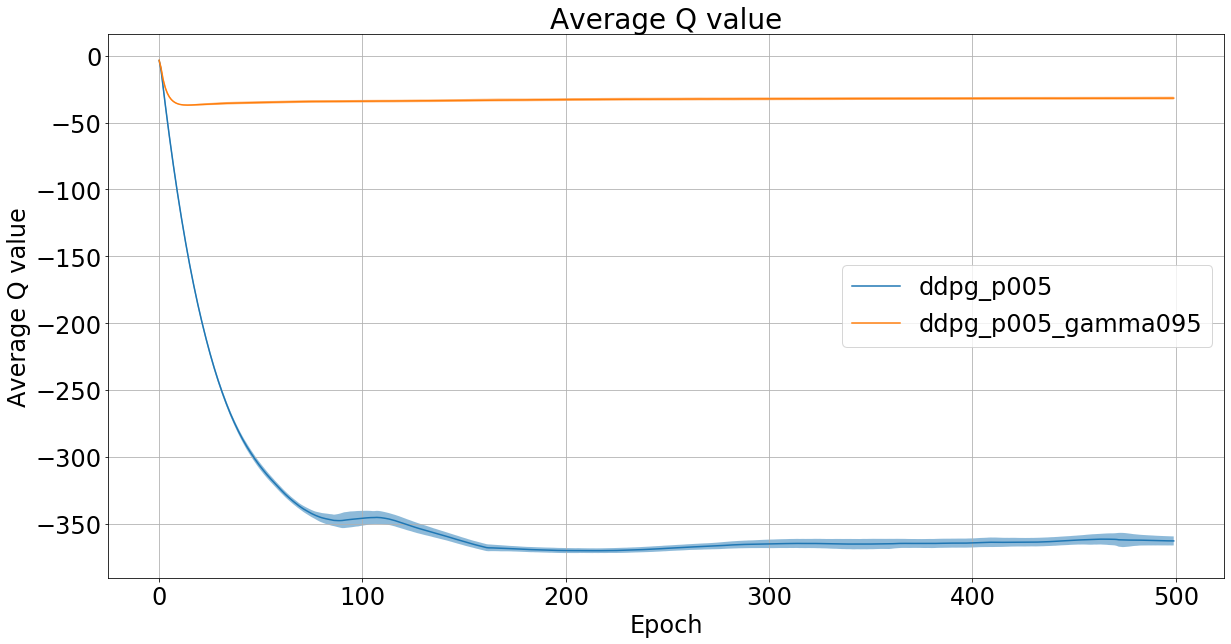

In [10]:
plt.figure(figsize=(20,10))
plt.title('Average Q value',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Q value',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['ddpg_p005','ddpg_p005_gamma095']

for agent_path in agent_paths:
    progress = read_progress(agent_path)
    plt.plot(np.arange(progress.shape[0]), progress[:,12])
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,14], progress[:,15], alpha=0.5)
    plt.fill_between(np.arange(progress.shape[0]), progress[:,12]+progress[:,13], progress[:,12]-progress[:,13], alpha=0.5)

plt.legend(agent_paths,fontsize=24)

In [11]:
assert False

AssertionError: 

## Why p = 0.05 doesn't learn with gamma = 0.995

In [ ]:
agent_path = 'ddpg_p005'
path = agent_path + '/pyt_save/model.pt'
ac = torch.load(path)

In [ ]:
gamma = 0.995
te = np.arange(-np.pi,np.pi,0.01)
es = np.zeros([len(te),1])
rs = np.zeros([len(te),1])
qs = np.zeros([len(te),1])
ys = np.zeros([len(te),1])
for i in range(len(te)):
    o = torch.as_tensor(env.reset([te[i],0,0,0,0,0,200/60*2*np.pi]), dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2, r, _, _ = env.step(a.detach().numpy())
    o2 = torch.as_tensor(o2, dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = r + gamma*q2
    es[i] = q - y
    rs[i] = r
    qs[i] = q
    ys[i] = y
plt.plot(qs)
plt.plot(ys)
# plt.plot(es/rs)
# plt.plot(es)

In [ ]:
gamma = 0.995
es = np.zeros([len(obs_record)-1,1])
rs = np.zeros([len(obs_record)-1,1])
qs = np.zeros([len(obs_record)-1,1])
ys = np.zeros([len(obs_record)-1,1])
for i in range(len(obs_record)-1):
    o = torch.as_tensor(obs_record[i], dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2 = torch.as_tensor(obs_record[i+1], dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = reward_record[i+1] + gamma*q2
    es[i] = q - y
    rs[i] = reward_record[i+1]
    qs[i] = q
    ys[i] = y
plt.plot(qs)
plt.plot(ys)
# plt.plot(es/rs)
# plt.plot(es)

In [ ]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x, y)

q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.show()

In [ ]:
agent_path = 'ddpg_p005_gamma095'
path = agent_path + '/pyt_save/model.pt'
ac = torch.load(path)

In [ ]:
gamma = 0.95
te = np.arange(-np.pi,np.pi,0.01)
e = np.zeros([len(te),1])
qs = np.zeros([len(te),1])
ys = np.zeros([len(te),1])
for i in range(len(te)):
    o = torch.as_tensor(env.reset([te[i],0,0,0,0,0,200/60*2*np.pi]), dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2, r, _, _ = env.step(a.detach().numpy())
    o2 = torch.as_tensor(o2, dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = r + gamma*q2
    e[i] = q - y
    qs[i] = q
    ys[i] = y
plt.scatter(te, qs)
# plt.plot(ys)
# plt.scatter(te, e)

In [ ]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x, y)

q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.show()